### Init

In [ ]:
import os

import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from datasets import load_dataset
from scripts.sam_results import SAMResults
from utils import (get_coco_style_polygons, pad_to_fixed_size,
                   resize_preserve_aspect_ratio)

In [ ]:
from grounded_sam import (
    run_grounded_sam_batch,
    transform_image_dino,
    transform_image_sam,
)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Config

In [ ]:
import yaml


def load_yaml(path):
    with open(path, "r") as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    return data

def get_labels_dict(config_path):
    data = load_yaml(config_path)
    labels_dict = data.get("names")
    labels_dict = {v: k for k, v in labels_dict.items()}
    return labels_dict

config_path = "configs/fashion_people.yml"
data = load_yaml(config_path)
labels_dict = get_labels_dict(config_path)

In [ ]:
def get_masks_md(results):
    results_list = []
    for result in results.formatted_results:
        mask = result.get("mask")
        coco_polygons = get_coco_style_polygons(mask)

        # format the polygons
        result.update({"polygons": coco_polygons})
        result.pop("mask")
        results_list.append(result)
    return results_list

In [ ]:
labels = [k for k, v in labels_dict.items()]
text_prompt = " . ".join(labels)
text_prompt

### Dataset & Dataloader

In [ ]:
global cache_dir
cache_dir = "../hf_datasets"

In [ ]:
def resize_image_pil(image_pil):
    if image_pil.mode != "RGB":
        image_pil = image_pil.convert("RGB")
    image_pil = resize_preserve_aspect_ratio(image_pil, 1024)
    image_pil = pad_to_fixed_size(image_pil, (1024, 1024))
    return image_pil


class Segmentation(Dataset):
    def __init__(self, dataset_id=None, image_col="image", image_id_col=None):
        self.ds = load_dataset(
            dataset_id, split="train", trust_remote_code=True, cache_dir=cache_dir, num_proc=os.cpu_count()
        )
        self.image_col = image_col
        self.image_id_col = image_id_col
        self.imgsz = 1024

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        # Get Image ID defaults to index
        image_id = item.get(self.image_id_col, idx)

        # Get PIL Image
        image_pil = item[self.image_col]
        # if image_pil.size[0] != self.imgsz or image_pil.size[1] != self.imgsz:
        #     image_pil = resize_image_pil(image_pil)
        image_pil = resize_image_pil(image_pil)


        # Process dino image
        dino_image = transform_image_dino(image_pil)

        # Process sam image
        sam_image = transform_image_sam(image_pil)

        return {"image_id": image_id, "dino_image": dino_image, "sam_image": sam_image, "image_pil": image_pil}

In [ ]:
# Enter the dataset ID and load it as a torch dataset
dataset_id = "jordandavis/fashion_num_people"
ds = Segmentation(dataset_id=dataset_id, image_col="image", image_id_col=None)

In [ ]:
# ds.ds = ds.ds.filter(lambda x: x['num_people'] > 0)
a = ds.ds['num_people']
b = [i for i, x in enumerate(a) if x > 0]
c = ds.ds.select(b)
ds.ds = c

In [ ]:
ds.ds = ds.ds.shuffle(seed=42)

In [ ]:
# def resize_image(examples):
#     # Check if examples['image'] is a list of images or a single image
#     if isinstance(examples['image'], list):
#         # If it's a list, process each image
#         examples['image'] = [resize_image_pil(image) for image in examples['image']]
#     else:
#         # If it's a single image, process the image directly
#         examples['image'] = resize_image_pil(examples['image'])
#     return examples

# ds.ds = ds.ds.map(resize_image, batched=True)

In [ ]:
# Dataloader
def collate_fn(ex):
    dino_images = torch.stack([e["dino_image"] for e in ex])
    sam_images = torch.stack([e["sam_image"] for e in ex])
    image_ids = [e["image_id"] for e in ex]
    pil_images = [e["image_pil"] for e in ex]
    return dict(image_ids=image_ids, dino_images=dino_images, sam_images=sam_images, pil_images=pil_images)


batch_size = 8
num_workers = os.cpu_count()

dataloader = DataLoader(
    ds,
    collate_fn=collate_fn,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    shuffle=False,
)

### Run Inference

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
masks_md = []
with tqdm(total=len(dataloader)) as pbar:
    for batch in dataloader:
        image_ids = batch.get("image_ids")
        images = batch.get("pil_images")

        with torch.no_grad():
            dino_images = batch.get("dino_images").to(device)
            sam_images = batch.get("sam_images").to(device)
            raw_results = run_grounded_sam_batch(dino_images, sam_images, text_prompt)

        for image_id, image, raw_result in zip(image_ids, images, raw_results):
            if raw_result.get('masks') is None or ('person' not in raw_result.get("phrases")):
                mask_md = None
            else:
                result = SAMResults(image, labels_dict, **raw_result)
                mask_md = get_masks_md(result)

            masks_md.append(mask_md)
        pbar.update(1)

In [ ]:
# import json 
# with open("results.json", 'w') as f:
#     f.write(json.dumps(masks_md, indent=4))

In [17]:
import gc
gc.collect() 
torch.cuda.empty_cache()

In [18]:
len(masks_md)

24912

In [20]:
updated_ds = ds.ds.take(len(masks_md))

In [21]:
import json
from datasets import Value
from huggingface_hub import create_repo

updated_ds = updated_ds.add_column("mask_metadata", masks_md)
# updated_ds = updated_ds.cast_column("width", Value("int16"))
# updated_ds = updated_ds.cast_column("height", Value("int16"))

Flattening the indices:   0%|          | 0/24912 [00:00<?, ? examples/s]

face


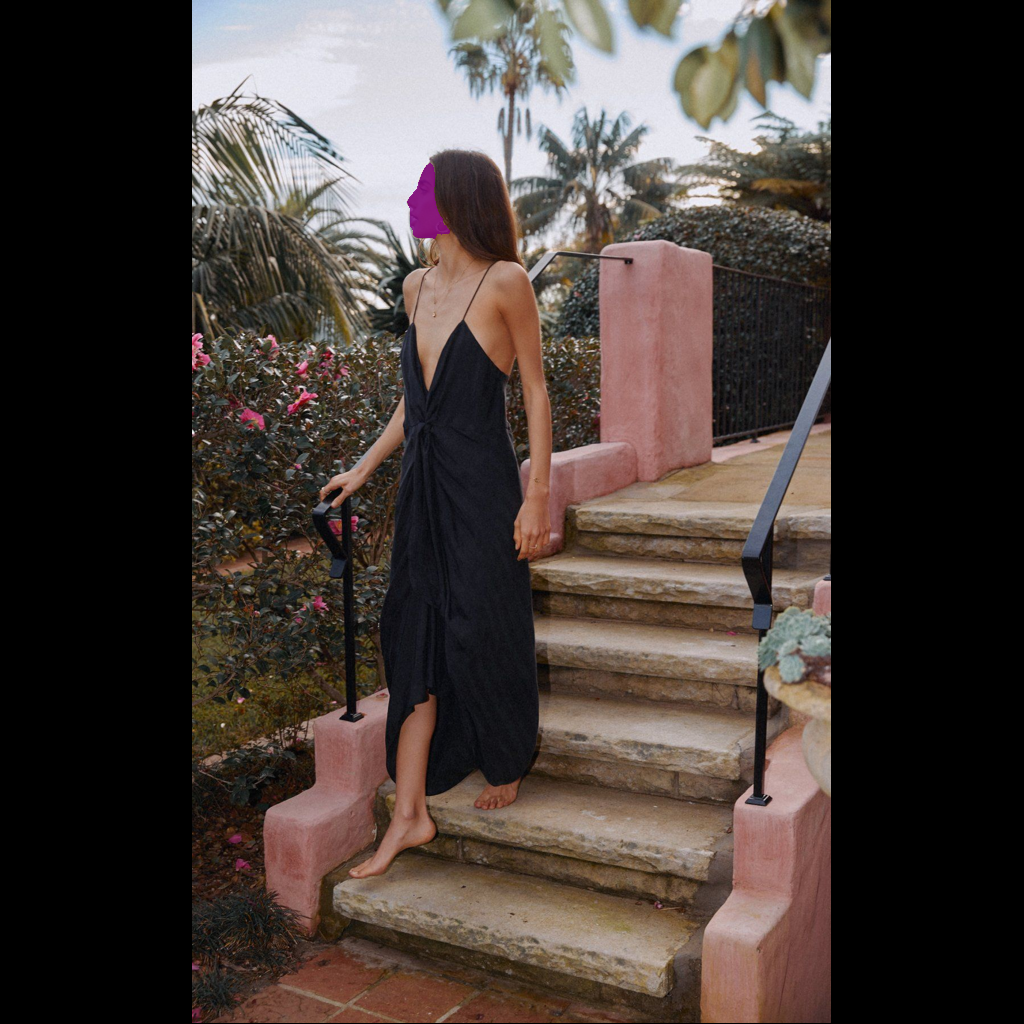

In [30]:
from utils import convert_coco_polygons_to_mask, overlay_mask
from PIL import Image 

def sanity_check(ds, row=102, mask_row=2):
    image = ds[row]['image']
    image = resize_image_pil(image)

    polygons = ds[row]['mask_metadata'][mask_row]['polygons']
    label = ds[row]['mask_metadata'][mask_row]['label']
    
    mask = convert_coco_polygons_to_mask(polygons, 1024, 1024)
    mask_image = Image.fromarray(mask)
    overlay = overlay_mask(image, mask_image, opacity=0.8)

    print(label)
    display(overlay)

row = 3
mask_row = 0
sanity_check(updated_ds, row, mask_row)

In [31]:
# Filter out rows with no mask_metadata
a = updated_ds['mask_metadata']
b = [i for i, x in enumerate(a) if x is not None]
updated_ds = updated_ds.select(b)
len(updated_ds)

23279

In [33]:
new_repo_id = "jordandavis/fashion_people_detections"
create_repo(
    repo_id=new_repo_id,
    repo_type="dataset",
    exist_ok=True,
)

RepoUrl('https://huggingface.co/datasets/jordandavis/fashion_people_detections', endpoint='https://huggingface.co', repo_type='dataset', repo_id='jordandavis/fashion_people_detections')

In [34]:
updated_ds.push_to_hub(new_repo_id, commit_message="md")

Uploading the dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1164 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1163 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/jordandavis/fashion_people_detections/commit/35b8588ce776d803ce3320c7afe50c0d392f91b1', commit_message='md', commit_description='', oid='35b8588ce776d803ce3320c7afe50c0d392f91b1', pr_url=None, pr_revision=None, pr_num=None)